In [ ]:
!pip install -q qiskit qiskit-nature qiskit-aer pyscf qiskit_algorithms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 9.3 MB/s eta 0:00:00


In [ ]:
# pylint: disable=line-too-long
import qiskit_nature
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_algorithms.optimizers import SLSQP,SPSA
from qiskit_nature.second_q.transformers import FreezeCoreTransformer, ActiveSpaceTransformer
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock

qiskit_nature.settings.use_pauli_sum_op = False  # pylint: disable=undefined-variable
# pylint: enable=line-too-long
from qiskit_nature.second_q.drivers import PySCFDriver
import matplotlib.pyplot as plt
from qiskit.circuit.library import EfficientSU2
import numpy as np
import pyscf



from qiskit_nature.second_q.algorithms import ExcitedStatesEigensolver
from qiskit_algorithms import NumPyEigensolver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, QEOM, EvaluationRule
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.mappers import JordanWignerMapper

## Noiseless stuff

In [ ]:
from qiskit_aer.primitives import Estimator

def get_qubit_op(dist):
    molecule = MoleculeInfo(
        symbols=["Li", "H"],
        coords=([0.0, 0.0, 0.0], [dist, 0.0, 0.0]), # 1.59 A - real distance between bond
        multiplicity=1,
        charge=0,
    )

    driver = PySCFDriver.from_molecule(molecule)

    properties = driver.run()

    problem = FreezeCoreTransformer(
        freeze_core=True, remove_orbitals=[-3, -2]
    ).transform(properties)

    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals

    mapper = ParityMapper(num_particles=num_particles)
    qubit_op = mapper.map(problem.second_q_ops()[0])
    return qubit_op, num_particles, num_spatial_orbitals, problem, mapper

In [ ]:
from qiskit_aer.primitives import Estimator


def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result


distances = np.arange(0.5, 4.0, 0.2)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=10)
noiseless_estimator = Estimator(approximation=True)

# pylint: disable=undefined-loop-variable,line-too-long
for dist in distances:

    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op(
        dist
    )

    result = exact_solver(qubit_op, problem)
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
    var_form = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )
    vqe = VQE(
        noiseless_estimator,
        var_form,
        optimizer,
        initial_point=[0] * var_form.num_parameters,
    )
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    print(
        f"Interatomic Distance: {np.round(dist, 2)}",
        f"VQE Result: {vqe_result:.5f}",
        f"Exact Energy: {exact_energies[-1]:.5f}",
    )

print("All energies have been calculated")

/usr/local/lib/python3.10/dist-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


Interatomic Distance: 0.5 VQE Result: -7.04791 Exact Energy: -7.04791
Interatomic Distance: 0.7 VQE Result: -7.50400 Exact Energy: -7.50400
Interatomic Distance: 0.9 VQE Result: -7.72283 Exact Energy: -7.72283
Interatomic Distance: 1.1 VQE Result: -7.82520 Exact Energy: -7.82520
Interatomic Distance: 1.3 VQE Result: -7.86890 Exact Energy: -7.86890
Interatomic Distance: 1.5 VQE Result: -7.88214 Exact Energy: -7.88214
Interatomic Distance: 1.7 VQE Result: -7.87920 Exact Energy: -7.87920
Interatomic Distance: 1.9 VQE Result: -7.86799 Exact Energy: -7.86799
Interatomic Distance: 2.1 VQE Result: -7.85320 Exact Energy: -7.85320
Interatomic Distance: 2.3 VQE Result: -7.83772 Exact Energy: -7.83772
Interatomic Distance: 2.5 VQE Result: -7.82343 Exact Energy: -7.82343
Interatomic Distance: 2.7 VQE Result: -7.81142 Exact Energy: -7.81142
Interatomic Distance: 2.9 VQE Result: -7.80215 Exact Energy: -7.80215
Interatomic Distance: 3.1 VQE Result: -7.79545 Exact Energy: -7.79545
Interatomic Distance

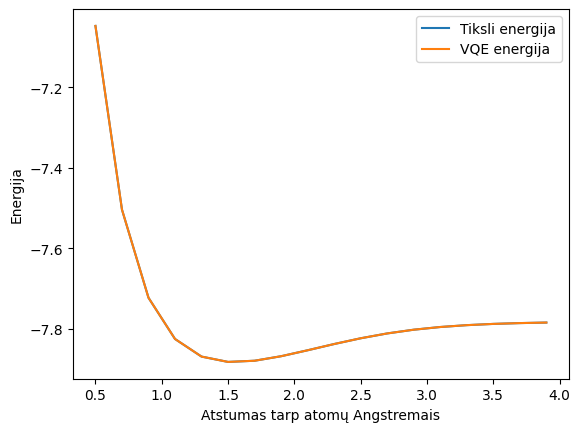

In [ ]:
plt.plot(distances, exact_energies, label="Tiksli energija")
plt.plot(distances, vqe_energies, label="VQE energija")
plt.xlabel("Atstumas tarp atomų Angstremais")
plt.ylabel("Energija")
plt.legend()
plt.show()

## Excited stuff

In [ ]:
from qiskit.primitives import Estimator



def get_problem(dist):

    molecule = MoleculeInfo(
        symbols=["Li", "H"],
        coords=([0.0, 0.0, 0.0], [1.59, 0.0, 0.0]), # 1.59 A - real distance between bond
        multiplicity=1,
        charge=0,
    )

    driver = PySCFDriver.from_molecule(molecule)


    properties = driver.run()

    problem =  ActiveSpaceTransformer(num_electrons=2, num_spatial_orbitals=2).transform(properties)

    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals



    mapper = ParityMapper()
    return num_particles, num_spatial_orbitals, problem, mapper


In [ ]:
optimizer = SLSQP(maxiter=10)
noiseless_estimator = Estimator()


def filter_criterion(eigenstate, eigenvalue, aux_values):
    return np.isclose(aux_values["ParticleNumber"][0], 2.0) and np.isclose(
        aux_values["Magnetization"][0], 0.0
    )


exact_energies=[]

qeomvqe_energies=[]


distances = [1]



numpy_solver = NumPyEigensolver(k=4, filter_criterion=filter_criterion)

for dist in distances:

    (num_particles, num_spatial_orbitals, problem, mapper) = get_problem(dist)


    numpy_solver = NumPyEigensolver(k=4, filter_criterion=filter_criterion)

    numpy_excited_states_solver = ExcitedStatesEigensolver(mapper, numpy_solver)
    numpy_results = numpy_excited_states_solver.solve(problem)

    print(numpy_results)
    init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
    var_form = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )
    vqe = VQE(
        noiseless_estimator,
        var_form,
        optimizer,
        initial_point=[0.0] * var_form.num_parameters,
    )

    gse = GroundStateEigensolver(mapper, vqe)

    qeom_excited_states_solver = QEOM(gse, noiseless_estimator, "sd", EvaluationRule.ALL)

    qeom_results = qeom_excited_states_solver.solve(problem)

    # print(
    #     f"Interatomic Distance: {np.round(dist, 2)}",
    #     f"VQE Result: {vqe_result:.5f}",
    #     f"Exact Energy: {exact_energies[-1]:.5f}",
    # )

    # print(
    #     f"Interatomic Distance: {np.round(dist, 2)}")
    # print(numpy_results.total_energies)
    # print("\n\n")
    # # print(qeom_results)
    # print(qeom_results.total_energies)
    # print("-------------------------------------")

    exact_energies.append(numpy_results)
    qeomvqe_energies.append(qeom_results)

print("All energies have been calculated")

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.860881705408
  - computed part:      -1.060505747127
  - ActiveSpaceTransformer extracted energy part: -7.800375958281
~ Nuclear repulsion energy (Hartree): 0.998447567774
> Total ground state energy (Hartree): -7.862434137635
 
=== EXCITED STATE ENERGIES ===
 
  1: 
* Electronic excited state energy (Hartree): -8.705865512264
> Total excited state energy (Hartree): -7.707417944491
  2: 
* Electronic excited state energy (Hartree): -8.163478330729
> Total excited state energy (Hartree): -7.165030762955
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
  1:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
  2:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [3.00466454  0.0  0.0]
 
  0: 
  * Electronic dipole moment (a.u.): [4.90040656909  0.0  0.0]
    - computed part:      [4.904442977872  0.0  0.0]
    - ActiveSp

In [ ]:
print(exact_energies[0])

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.860881705408
  - computed part:      -1.060505747127
  - ActiveSpaceTransformer extracted energy part: -7.800375958281
~ Nuclear repulsion energy (Hartree): 0.998447567774
> Total ground state energy (Hartree): -7.862434137635
 
=== EXCITED STATE ENERGIES ===
 
  1: 
* Electronic excited state energy (Hartree): -8.705865512264
> Total excited state energy (Hartree): -7.707417944491
  2: 
* Electronic excited state energy (Hartree): -8.163478330729
> Total excited state energy (Hartree): -7.165030762955
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
  1:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
  2:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [3.00466454  0.0  0.0]
 
  0: 
  * Electronic dipole moment (a.u.): [4.90040656909  0.0  0.0]
    - computed part:      [4.904442977872  0.0  0.0]
    - ActiveSp

In [ ]:
print(qeomvqe_energies[0])


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.860881679739
  - computed part:      -1.060505721457
  - ActiveSpaceTransformer extracted energy part: -7.800375958281
~ Nuclear repulsion energy (Hartree): 0.998447567774
> Total ground state energy (Hartree): -7.862434111965
 
=== EXCITED STATE ENERGIES ===
 
  1: 
* Electronic excited state energy (Hartree): -8.720098806002
> Total excited state energy (Hartree): -7.721651238228
  2: 
* Electronic excited state energy (Hartree): -8.705871753862
> Total excited state energy (Hartree): -7.707424186088
  3: 
* Electronic excited state energy (Hartree): -8.163482300596
> Total excited state energy (Hartree): -7.165034732822
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
  1:  # Particles: 2.000 S: 1.000 S^2: 2.000 M: 0.000
  2:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: -0.000
  3:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipol

#Noisy stuff

In [ ]:
from qiskit_aer.primitives import Estimator


molecule = MoleculeInfo(
    # Coordinates in Angstrom
    symbols=["Li", "H"],
    coords=([0.0, 0.0, 0.0], [dist, 0.0, 0.0]),
    multiplicity=1,  # = 2*spin + 1
    charge=0,
)

driver = PySCFDriver.from_molecule(molecule)

# Get properties
properties = driver.run()

# Now you can get the reduced electronic structure problem
problem = FreezeCoreTransformer(
    freeze_core=True, remove_orbitals=[-3, -2]
).transform(properties)

num_particles = problem.num_particles
num_spatial_orbitals = problem.num_spatial_orbitals

mapper = ParityMapper(num_particles=num_particles)
qubit_op = mapper.map(problem.second_q_ops()[0])

In [ ]:

from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeVigo

# fake providers contain data from real IBM Quantum devices stored
# in Qiskit Terra, and are useful for extracting realistic noise models.

device = FakeVigo()
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
noisy_estimator = Estimator(
    backend_options={"coupling_map": coupling_map, "noise_model": noise_model}
)



In [ ]:
def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result


exact_energies = []
vqe_energies = []
result = exact_solver(qubit_op, problem)
exact_energies.append(result.total_energies)

print("Exact Result:", result.total_energies)
optimizer = SPSA(maxiter=10)
var_form = EfficientSU2(qubit_op.num_qubits, entanglement="linear")
vqe = VQE(noisy_estimator, var_form, optimizer)
vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
vqe_result = problem.interpret(vqe_calc).total_energies
print("VQE Result:", vqe_result)

Exact Result: [-7.88236229]
